# Flag Boundary Detection and Classification

This notebook analyzes historical data to **find the boundaries between different flag statuses** based on water level differentials.

## Approach

Instead of using a complex machine learning model (like RandomForest), we:

1. **Analyze the distribution** of differential values for each flag status (Green, Amber, Red, etc.)
2. **Identify the natural boundaries** where one flag transitions to another
3. **Create a simple threshold-based classifier** that uses these boundaries

## Benefits

- **Interpretable**: Clear thresholds show exactly when flags change
- **Efficient**: Simple comparisons instead of complex model inference
- **Reliable**: Based on actual data patterns from historical observations
- **Easy to debug**: Can see exactly which boundary was crossed

## Locations

- **Godstow**: 3 flag statuses (Green, Amber, Red)
- **Isis**: 5 flag statuses (Green, Light Blue, Dark Blue, Amber, Red)


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import requests
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
import glob

from sklearn.ensemble import RandomForestClassifier


# PyTorch imports for LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device (MPS for Apple Silicon, CUDA for NVIDIA, CPU otherwise)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS (GPU) acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU) acceleration")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Set the working directory
os.chdir('/Users/robertds413/Documents/Flag_Predictor')
print(f"Device: {device}")
print(f"Working directory: {os.getcwd()}")


Using CPU
Device: cpu
Working directory: /Users/robertds413/Documents/Flag_Predictor


In [2]:
def process_lock_api_data(data):
    """Process API data from flood monitoring service"""
    if 'items' not in data or not data['items']:
        return pd.DataFrame()
    
    temp_df = pd.DataFrame(data['items'])
    if 'dateTime' not in temp_df.columns or 'value' not in temp_df.columns:
        return pd.DataFrame()
    
    temp_df = temp_df[['dateTime', 'value']]
    temp_df.rename(columns={'dateTime': 'timestamp', 'value': 'level'}, inplace=True)
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
    df = temp_df.set_index('timestamp')
    return df

def process_rainfall_api_data(data):
    """Process rainfall API data from flood monitoring service"""
    if 'items' not in data or not data['items']:
        return pd.DataFrame()
    
    temp_df = pd.DataFrame(data['items'])
    if 'dateTime' not in temp_df.columns or 'value' not in temp_df.columns:
        return pd.DataFrame()
    
    temp_df = temp_df[['dateTime', 'value']]
    temp_df.rename(columns={'dateTime': 'timestamp', 'value': 'rainfall'}, inplace=True)
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
    df = temp_df.set_index('timestamp')
    return df

def load_flag_model_data(file_path, differential_column):
    """Load flag model training data from CSV file"""
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df = df[[differential_column]]
    df = df.rename(columns={differential_column: 'differential'})
    return df

print("✓ Data loading functions defined")


✓ Data loading functions defined


In [3]:
# Load historical differential data
print("\nLoading historical differential data...")
godstow_hist_diff_df = load_flag_model_data('data/godstow_flag_model_data.csv', 'jameson_godstow_differential')
isis_hist_diff_df = load_flag_model_data('data/isis_flag_model_data.csv', 'jameson_isis_differential')
godstow_hist_flag_df = load_flag_model_data('data/godstow_flag_model_data.csv', 'godstow_flag_status')
isis_hist_flag_df = load_flag_model_data('data/isis_flag_model_data.csv', 'isis_flag_status')
print(f"✓ ISIS historical differential: {isis_hist_diff_df.shape}")
print(f"✓ Godstow historical differential: {godstow_hist_diff_df.shape}")


Loading historical differential data...
✓ ISIS historical differential: (204120, 1)
✓ Godstow historical differential: (32122, 1)


In [4]:
# Remove grey flag dates from historical data
print("\nRemoving grey flag dates...")
godstow_hist_diff_df = godstow_hist_diff_df[godstow_hist_flag_df['differential'] != 'Godstow - Grey']
isis_hist_diff_df = isis_hist_diff_df[isis_hist_flag_df['differential'] != 'Isis - Grey']
print(f"✓ ISIS historical differential after filtering: {isis_hist_diff_df.shape}")
print(f"✓ Godstow historical differential after filtering: {godstow_hist_diff_df.shape}")


Removing grey flag dates...
✓ ISIS historical differential after filtering: (123683, 1)
✓ Godstow historical differential after filtering: (19235, 1)


In [20]:
# Remove data from October 2023 to May 2024 for Isis, and before September 2021
print("\nFiltering Isis data...")
print(f"Isis data before filtering: {isis_hist_diff_df.shape}")
print(f"Isis flag data before filtering: {isis_hist_flag_df.shape}")

# Define the date ranges to exclude
exclude_start_2023 = pd.Timestamp('2023-10-01', tz='UTC')
exclude_end_2024 = pd.Timestamp('2024-05-31 23:59:59', tz='UTC')
include_start_2021 = pd.Timestamp('2021-09-01', tz='UTC')

# Filter out the date ranges for Isis differential data
isis_hist_diff_df = isis_hist_diff_df[
    (isis_hist_diff_df.index >= include_start_2021) &
    ((isis_hist_diff_df.index < exclude_start_2023) | 
     (isis_hist_diff_df.index > exclude_end_2024))
]

# Filter out the date ranges for Isis flag data
isis_hist_flag_df = isis_hist_flag_df[
    (isis_hist_flag_df.index >= include_start_2021) &
    ((isis_hist_flag_df.index < exclude_start_2023) | 
     (isis_hist_flag_df.index > exclude_end_2024))
]

print(f"✓ Isis data after filtering: {isis_hist_diff_df.shape}")
print(f"✓ Isis flag data after filtering: {isis_hist_flag_df.shape}")
print(f"  Removed data before {include_start_2021.strftime('%Y-%m-%d')}")
print(f"  Removed {exclude_start_2023.strftime('%Y-%m-%d')} to {exclude_end_2024.strftime('%Y-%m-%d')}")

# Godstow data remains unchanged
print(f"\nGodstow data (unchanged): {godstow_hist_diff_df.shape}")



Filtering Isis data...
Isis data before filtering: (58037, 1)
Isis flag data before filtering: (104594, 1)
✓ Isis data after filtering: (58037, 1)
✓ Isis flag data after filtering: (104594, 1)
  Removed data before 2021-09-01
  Removed 2023-10-01 to 2024-05-31

Godstow data (unchanged): (19235, 1)


In [21]:
# Remove grey flag dates from historical data
print("\nRemoving grey flag dates...")
godstow_hist_diff_df = godstow_hist_diff_df[godstow_hist_flag_df['differential'] != 'Godstow - Grey']
isis_hist_diff_df = isis_hist_diff_df[isis_hist_flag_df['differential'] != 'Isis - Grey']

# Drop NaN values
godstow_hist_diff_df = godstow_hist_diff_df.dropna()
isis_hist_diff_df = isis_hist_diff_df.dropna()

print(f"✓ ISIS historical differential after filtering: {isis_hist_diff_df.shape}")
print(f"✓ Godstow historical differential after filtering: {godstow_hist_diff_df.shape}")


Removing grey flag dates...


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_78832/3339151751.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  godstow_hist_diff_df = godstow_hist_diff_df[godstow_hist_flag_df['differential'] != 'Godstow - Grey']
/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_78832/3339151751.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  isis_hist_diff_df = isis_hist_diff_df[isis_hist_flag_df['differential'] != 'Isis - Grey']


✓ ISIS historical differential after filtering: (58037, 1)
✓ Godstow historical differential after filtering: (19235, 1)


In [22]:
# Train simple models to predict flag status from differential
print("\nTraining flag prediction models...")

# Prepare Godstow training data
# Filter flag data to match the filtered differential data indices
godstow_hist_flag_filtered = godstow_hist_flag_df[godstow_hist_flag_df.index.isin(godstow_hist_diff_df.index)]
godstow_hist_flag_filtered = godstow_hist_flag_filtered[godstow_hist_flag_filtered['differential'] != 'Godstow - Grey']
godstow_hist_flag_filtered = godstow_hist_flag_filtered.dropna()

# Align the indices
common_godstow_indices = godstow_hist_diff_df.index.intersection(godstow_hist_flag_filtered.index)
godstow_X = godstow_hist_diff_df.loc[common_godstow_indices].values
godstow_y = godstow_hist_flag_filtered.loc[common_godstow_indices]['differential'].values

# Train Godstow model
godstow_model = RandomForestClassifier(n_estimators=100, random_state=42)
godstow_model.fit(godstow_X, godstow_y)
godstow_accuracy = godstow_model.score(godstow_X, godstow_y)
print(f"✓ Godstow model trained - Accuracy: {godstow_accuracy:.3f}")

# Prepare Isis training data
# Filter flag data to match the filtered differential data indices
isis_hist_flag_filtered = isis_hist_flag_df[isis_hist_flag_df.index.isin(isis_hist_diff_df.index)]
isis_hist_flag_filtered = isis_hist_flag_filtered[isis_hist_flag_filtered['differential'] != 'Isis - Grey']
isis_hist_flag_filtered = isis_hist_flag_filtered.dropna()

# Align the indices
common_isis_indices = isis_hist_diff_df.index.intersection(isis_hist_flag_filtered.index)
isis_X = isis_hist_diff_df.loc[common_isis_indices].values
isis_y = isis_hist_flag_filtered.loc[common_isis_indices]['differential'].values

# Train Isis model
isis_model = RandomForestClassifier(n_estimators=100, random_state=42)
isis_model.fit(isis_X, isis_y)
isis_accuracy = isis_model.score(isis_X, isis_y)
print(f"✓ Isis model trained - Accuracy: {isis_accuracy:.3f}")

# Show unique flag classes
print(f"\nGodstow flag classes: {sorted(set(godstow_y))}")
print(f"Isis flag classes: {sorted(set(isis_y))}")

# Analyze decision thresholds from the trained models
print("\nAnalyzing decision thresholds...")

# For Godstow model
print("\nGodstow thresholds:")
godstow_feature_importances = godstow_model.feature_importances_
print(f"Feature importance: {godstow_feature_importances}")

# Get decision boundaries by examining predictions across a range of differential values
godstow_diff_range = np.linspace(godstow_X.min(), godstow_X.max(), 1000).reshape(-1, 1)
godstow_predictions = godstow_model.predict(godstow_diff_range)

# Find threshold points where predictions change
godstow_changes = np.where(godstow_predictions[:-1] != godstow_predictions[1:])[0]
print(f"Decision boundaries at differential values:")
for idx in godstow_changes:
    print(f"  {godstow_diff_range[idx][0]:.4f} -> {godstow_diff_range[idx+1][0]:.4f}: {godstow_predictions[idx]} to {godstow_predictions[idx+1]}")

# For Isis model
print("\nIsis thresholds:")
isis_feature_importances = isis_model.feature_importances_
print(f"Feature importance: {isis_feature_importances}")

# Get decision boundaries by examining predictions across a range of differential values
isis_diff_range = np.linspace(isis_X.min(), isis_X.max(), 1000).reshape(-1, 1)
isis_predictions = isis_model.predict(isis_diff_range)

# Find threshold points where predictions change
isis_changes = np.where(isis_predictions[:-1] != isis_predictions[1:])[0]
print(f"Decision boundaries at differential values:")
for idx in isis_changes:
    print(f"  {isis_diff_range[idx][0]:.4f} -> {isis_diff_range[idx+1][0]:.4f}: {isis_predictions[idx]} to {isis_predictions[idx+1]}")




Training flag prediction models...
✓ Godstow model trained - Accuracy: 0.961
✓ Isis model trained - Accuracy: 0.980

Godstow flag classes: ['Godstow - Amber', 'Godstow - Green', 'Godstow - Red']
Isis flag classes: ['Isis - Amber', 'Isis - Dark Blue', 'Isis - Green', 'Isis - Light Blue', 'Isis - Red']

Analyzing decision thresholds...

Godstow thresholds:
Feature importance: [1.]
Decision boundaries at differential values:
  0.2589 -> 0.2602: Godstow - Green to Godstow - Amber
  0.2615 -> 0.2627: Godstow - Amber to Godstow - Green
  0.2729 -> 0.2742: Godstow - Green to Godstow - Amber
  0.2742 -> 0.2755: Godstow - Amber to Godstow - Green
  0.3619 -> 0.3632: Godstow - Green to Godstow - Amber
  0.3632 -> 0.3645: Godstow - Amber to Godstow - Green
  0.4318 -> 0.4331: Godstow - Green to Godstow - Amber
  0.4331 -> 0.4344: Godstow - Amber to Godstow - Green
  0.4344 -> 0.4356: Godstow - Green to Godstow - Amber
  0.4356 -> 0.4369: Godstow - Amber to Godstow - Green
  0.4369 -> 0.4382: God

In [23]:
def predict_flag_from_differential(differential_value, location):
    """
    Predict flag status from a differential value and location.
    
    Parameters:
    -----------
    differential_value : float
        The differential value (e.g., jameson_godstow_differential or jameson_isis_differential)
    location : str
        Location name, either 'Godstow' or 'Isis' (case-insensitive)
    
    Returns:
    --------
    str
        Predicted flag status (e.g., 'Godstow - Green', 'Isis - Red', etc.)
    
    Examples:
    ---------
    >>> predict_flag_from_differential(0.5, 'Godstow')
    'Godstow - Green'
    
    >>> predict_flag_from_differential(1.8, 'Isis')
    'Isis - Red'
    """
    # Normalize location input
    location = location.strip().lower()
    
    # Validate location
    if location not in ['godstow', 'isis']:
        raise ValueError(f"Invalid location: '{location}'. Must be 'Godstow' or 'Isis'")
    
    # Validate differential value
    if not isinstance(differential_value, (int, float)):
        raise TypeError(f"Differential value must be a number, got {type(differential_value)}")
    
    # Reshape input for sklearn (needs 2D array)
    input_data = np.array([[differential_value]])
    
    # Select appropriate model and make prediction
    if location == 'godstow':
        prediction = godstow_model.predict(input_data)[0]
    else:  # isis
        prediction = isis_model.predict(input_data)[0]
    
    return prediction


# Test the function with some examples
print("Testing the prediction function:\n")
print("=" * 60)

# Test Godstow predictions
print("\nGodstow predictions:")
print(f"Differential 0.3 → {predict_flag_from_differential(0.3, 'Godstow')}")
print(f"Differential 0.6 → {predict_flag_from_differential(0.6, 'Godstow')}")
print(f"Differential 0.9 → {predict_flag_from_differential(0.9, 'Godstow')}")

# Test Isis predictions
print("\nIsis predictions:")
print(f"Differential 1.0 → {predict_flag_from_differential(1.0, 'Isis')}")
print(f"Differential 1.5 → {predict_flag_from_differential(1.5, 'Isis')}")
print(f"Differential 2.0 → {predict_flag_from_differential(2.0, 'Isis')}")

print("\n" + "=" * 60)
print("✓ Function ready to use!")
print("\nUsage: predict_flag_from_differential(differential_value, location)")



Testing the prediction function:


Godstow predictions:
Differential 0.3 → Godstow - Green
Differential 0.6 → Godstow - Amber
Differential 0.9 → Godstow - Red

Isis predictions:
Differential 1.0 → Isis - Red
Differential 1.5 → Isis - Red
Differential 2.0 → Isis - Red

✓ Function ready to use!

Usage: predict_flag_from_differential(differential_value, location)


In [24]:
# Analyze flag boundaries
print("Analyzing flag boundaries from historical data...\n")
print("=" * 80)

def analyze_flag_boundaries(diff_df, flag_df, location_name):
    """
    Analyze the differential values for each flag status to find boundaries.
    """
    # Align the data
    common_indices = diff_df.index.intersection(flag_df.index)
    aligned_diff = diff_df.loc[common_indices]
    aligned_flags = flag_df.loc[common_indices]
    
    # Create a combined dataframe
    combined = pd.DataFrame({
        'differential': aligned_diff['differential'],
        'flag': aligned_flags['differential']
    })
    
    # Remove grey flags
    combined = combined[~combined['flag'].str.contains('Grey', na=False)]
    
    # Group by flag status and get statistics
    stats = combined.groupby('flag')['differential'].agg([
        ('count', 'count'),
        ('min', 'min'),
        ('max', 'max'),
        ('mean', 'mean'),
        ('median', 'median'),
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75))
    ]).sort_values('median')
    
    print(f"\n{location_name} Flag Statistics:")
    print("-" * 80)
    print(stats.to_string())
    
    # Find boundaries (using midpoints between adjacent flag medians)
    boundaries = {}
    sorted_flags = stats.index.tolist()
    sorted_medians = stats['median'].tolist()
    
    for i in range(len(sorted_flags) - 1):
        flag1 = sorted_flags[i]
        flag2 = sorted_flags[i + 1]
        
        # Use the midpoint between the max of lower flag and min of upper flag
        max_lower = stats.loc[flag1, 'max']
        min_upper = stats.loc[flag2, 'min']
        
        # If there's overlap, use median midpoint, otherwise use the gap midpoint
        if min_upper > max_lower:
            boundary = (max_lower + min_upper) / 2
        else:
            # Overlap case - use median midpoint
            boundary = (sorted_medians[i] + sorted_medians[i + 1]) / 2
        
        boundaries[f"{flag1} -> {flag2}"] = boundary
    
    print(f"\nSuggested boundaries:")
    for transition, boundary_value in boundaries.items():
        print(f"  {transition}: {boundary_value:.4f}")
    
    return stats, boundaries, combined

# Analyze Godstow
godstow_stats, godstow_boundaries, godstow_combined = analyze_flag_boundaries(
    godstow_hist_diff_df, 
    godstow_hist_flag_df, 
    "Godstow"
)

print("\n" + "=" * 80)

# Analyze Isis
isis_stats, isis_boundaries, isis_combined = analyze_flag_boundaries(
    isis_hist_diff_df, 
    isis_hist_flag_df, 
    "Isis"
)


Analyzing flag boundaries from historical data...


Godstow Flag Statistics:
--------------------------------------------------------------------------------
                 count    min    max      mean  median    q25     q75
flag                                                                 
Godstow - Green  11275 -0.036  0.537  0.123806   0.048  0.027  0.2140
Godstow - Amber   2815  0.260  0.912  0.522336   0.526  0.464  0.5895
Godstow - Red     5119  0.522  1.234  0.933890   0.918  0.817  1.0580

Suggested boundaries:
  Godstow - Green -> Godstow - Amber: 0.2870
  Godstow - Amber -> Godstow - Red: 0.7220


Isis Flag Statistics:
--------------------------------------------------------------------------------
                   count      min      max      mean    median       q25       q75
flag                                                                              
Isis - Green       40642 -2.06196  0.60452  0.041123  0.028410 -0.008640  0.080650
Isis - Light Blue   4311  0


Visualizing flag distributions and boundaries...


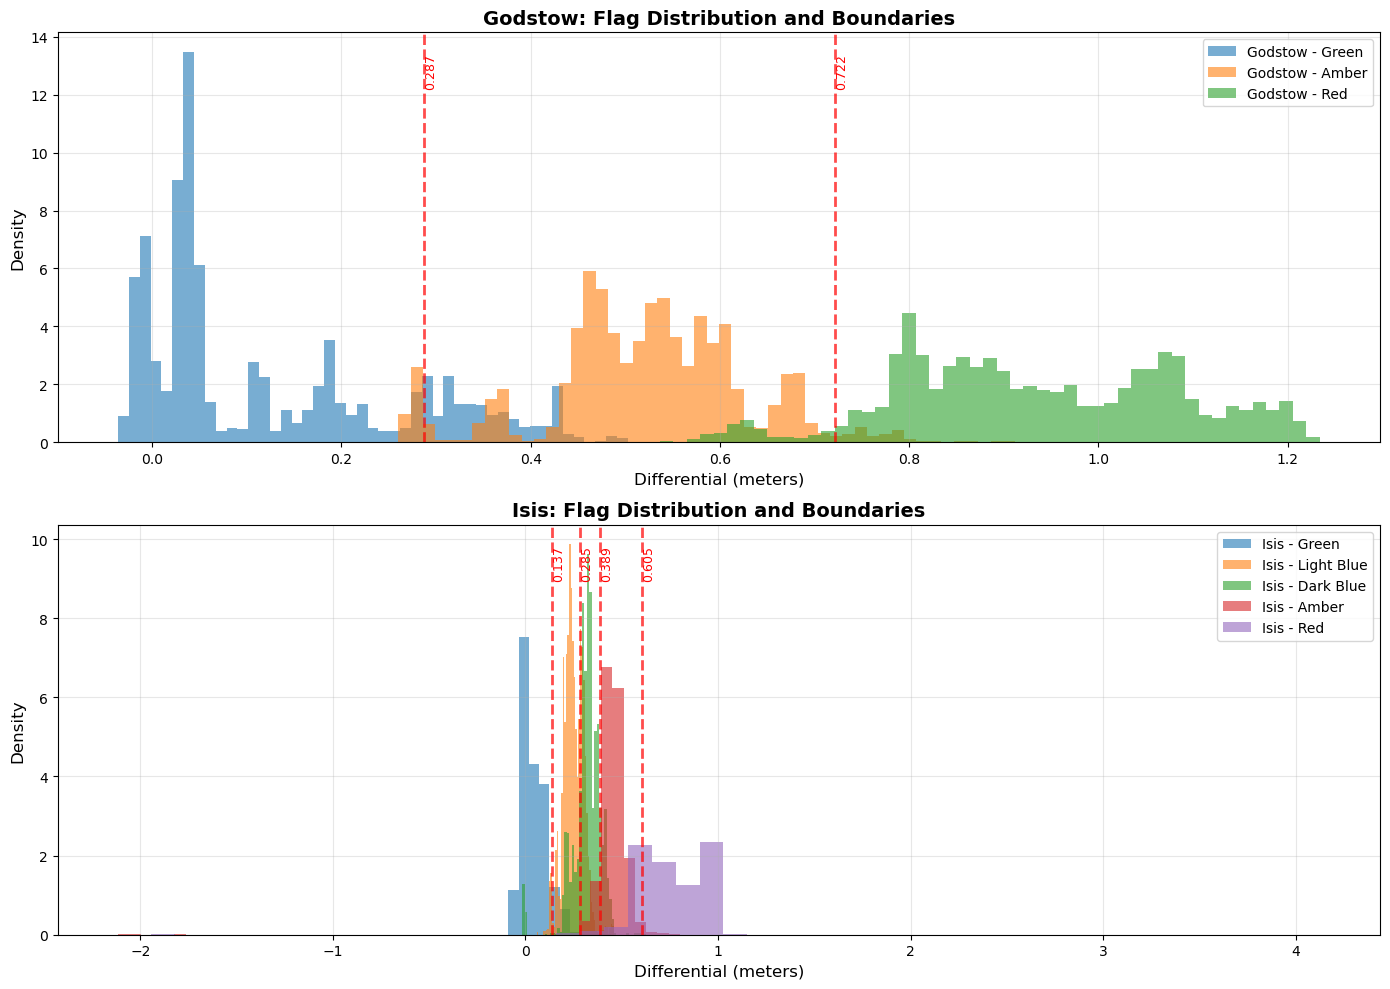

✓ Visualization complete


In [25]:
# Visualize flag distributions and boundaries
print("\nVisualizing flag distributions and boundaries...")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Godstow visualization
ax1 = axes[0]
for flag in godstow_stats.index:
    flag_data = godstow_combined[godstow_combined['flag'] == flag]['differential']
    ax1.hist(flag_data, bins=50, alpha=0.6, label=flag, density=True)

# Add boundary lines for Godstow
y_max = ax1.get_ylim()[1]
for transition, boundary_value in godstow_boundaries.items():
    ax1.axvline(boundary_value, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(boundary_value, y_max * 0.95, f'{boundary_value:.3f}', 
             rotation=90, verticalalignment='top', fontsize=9, color='red')

ax1.set_xlabel('Differential (meters)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Godstow: Flag Distribution and Boundaries', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Isis visualization
ax2 = axes[1]
for flag in isis_stats.index:
    flag_data = isis_combined[isis_combined['flag'] == flag]['differential']
    ax2.hist(flag_data, bins=50, alpha=0.6, label=flag, density=True)

# Add boundary lines for Isis
y_max = ax2.get_ylim()[1]
for transition, boundary_value in isis_boundaries.items():
    ax2.axvline(boundary_value, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(boundary_value, y_max * 0.95, f'{boundary_value:.3f}', 
             rotation=90, verticalalignment='top', fontsize=9, color='red')

ax2.set_xlabel('Differential (meters)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Isis: Flag Distribution and Boundaries', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")


In [26]:
# Create threshold-based classifier
print("\nCreating threshold-based flag classifier...")
print("=" * 80)

class FlagBoundaryClassifier:
    """
    A simple, interpretable threshold-based classifier for flag prediction.
    Uses learned boundaries from historical data.
    """
    
    def __init__(self, location_name, stats_df, boundaries_dict):
        """
        Initialize the classifier with location-specific boundaries.
        
        Parameters:
        -----------
        location_name : str
            Location name ('Godstow' or 'Isis')
        stats_df : pandas.DataFrame
            Statistics dataframe with flag info sorted by median differential
        boundaries_dict : dict
            Dictionary of boundary transitions and values
        """
        self.location_name = location_name
        self.flags = stats_df.index.tolist()  # Already sorted by median
        
        # Extract boundary thresholds in order
        self.thresholds = []
        for i in range(len(self.flags) - 1):
            transition_key = f"{self.flags[i]} -> {self.flags[i+1]}"
            if transition_key in boundaries_dict:
                self.thresholds.append(boundaries_dict[transition_key])
        
        print(f"\n{location_name} Classifier Initialized:")
        print(f"  Flags (ordered): {self.flags}")
        print(f"  Thresholds: {[f'{t:.4f}' for t in self.thresholds]}")
        self._print_rules()
    
    def _print_rules(self):
        """Print the classification rules."""
        print(f"\n  Classification Rules:")
        for i, flag in enumerate(self.flags):
            if i == 0:
                print(f"    {flag}: differential < {self.thresholds[0]:.4f}")
            elif i == len(self.flags) - 1:
                print(f"    {flag}: differential >= {self.thresholds[-1]:.4f}")
            else:
                print(f"    {flag}: {self.thresholds[i-1]:.4f} <= differential < {self.thresholds[i]:.4f}")
    
    def predict(self, differential_value):
        """
        Predict flag status based on differential value.
        
        Parameters:
        -----------
        differential_value : float
            The differential value
        
        Returns:
        --------
        str
            Predicted flag status
        """
        for i, threshold in enumerate(self.thresholds):
            if differential_value < threshold:
                return self.flags[i]
        return self.flags[-1]
    
    def predict_batch(self, differential_values):
        """
        Predict flag status for multiple differential values.
        
        Parameters:
        -----------
        differential_values : array-like
            Array of differential values
        
        Returns:
        --------
        list
            List of predicted flag statuses
        """
        return [self.predict(val) for val in differential_values]
    
    def get_boundaries(self):
        """Return the threshold boundaries."""
        return {
            f"{self.flags[i]} -> {self.flags[i+1]}": self.thresholds[i]
            for i in range(len(self.thresholds))
        }

# Create classifiers for both locations
godstow_classifier = FlagBoundaryClassifier(
    "Godstow",
    godstow_stats,
    godstow_boundaries
)

print("\n" + "=" * 80)

isis_classifier = FlagBoundaryClassifier(
    "Isis",
    isis_stats,
    isis_boundaries
)

print("\n" + "=" * 80)
print("\n✓ Threshold-based classifiers created!")



Creating threshold-based flag classifier...

Godstow Classifier Initialized:
  Flags (ordered): ['Godstow - Green', 'Godstow - Amber', 'Godstow - Red']
  Thresholds: ['0.2870', '0.7220']

  Classification Rules:
    Godstow - Green: differential < 0.2870
    Godstow - Amber: 0.2870 <= differential < 0.7220
    Godstow - Red: differential >= 0.7220


Isis Classifier Initialized:
  Flags (ordered): ['Isis - Green', 'Isis - Light Blue', 'Isis - Dark Blue', 'Isis - Amber', 'Isis - Red']
  Thresholds: ['0.1366', '0.2852', '0.3887', '0.6047']

  Classification Rules:
    Isis - Green: differential < 0.1366
    Isis - Light Blue: 0.1366 <= differential < 0.2852
    Isis - Dark Blue: 0.2852 <= differential < 0.3887
    Isis - Amber: 0.3887 <= differential < 0.6047
    Isis - Red: differential >= 0.6047


✓ Threshold-based classifiers created!


In [27]:
# Evaluate threshold-based classifier performance
print("\nEvaluating threshold-based classifiers...")
print("=" * 80)

def evaluate_classifier(classifier, combined_df):
    """Evaluate classifier accuracy on historical data."""
    predictions = classifier.predict_batch(combined_df['differential'].values)
    actual = combined_df['flag'].values
    
    correct = sum(p == a for p, a in zip(predictions, actual))
    total = len(predictions)
    accuracy = correct / total
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(actual, predictions, labels=classifier.flags)
    
    print(f"\n{classifier.location_name} Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f} ({correct}/{total} correct)")
    print(f"\n  Confusion Matrix:")
    
    # Print confusion matrix nicely
    print(f"  {'Actual \\ Predicted':<25}", end="")
    for flag in classifier.flags:
        print(f"{flag.split(' - ')[1]:<12}", end="")
    print()
    
    for i, flag in enumerate(classifier.flags):
        print(f"  {flag.split(' - ')[1]:<25}", end="")
        for j in range(len(classifier.flags)):
            print(f"{cm[i][j]:<12}", end="")
        print()
    
    print(f"\n  Classification Report:")
    report = classification_report(actual, predictions, labels=classifier.flags, zero_division=0)
    print("  " + "\n  ".join(report.split("\n")))
    
    return accuracy

# Evaluate Godstow classifier
godstow_accuracy = evaluate_classifier(godstow_classifier, godstow_combined)

print("\n" + "=" * 80)

# Evaluate Isis classifier
isis_accuracy = evaluate_classifier(isis_classifier, isis_combined)

print("\n" + "=" * 80)
print(f"\n✓ Evaluation complete!")
print(f"  Godstow Accuracy: {godstow_accuracy:.4f}")
print(f"  Isis Accuracy: {isis_accuracy:.4f}")


SyntaxError: f-string expression part cannot include a backslash (3570732673.py, line 24)

In [28]:
# Create simple prediction function using threshold-based classifier
def predict_flag_from_differential_v2(differential_value, location):
    """
    Predict flag status from a differential value using threshold-based classification.
    
    This version uses learned boundaries from historical data rather than a RandomForest model.
    It's more interpretable and shows exactly which thresholds separate different flag statuses.
    
    Parameters:
    -----------
    differential_value : float
        The differential value (e.g., jameson_godstow_differential or jameson_isis_differential)
    location : str
        Location name, either 'Godstow' or 'Isis' (case-insensitive)
    
    Returns:
    --------
    str
        Predicted flag status (e.g., 'Godstow - Green', 'Isis - Red', etc.)
    
    Examples:
    ---------
    >>> predict_flag_from_differential_v2(0.5, 'Godstow')
    'Godstow - Amber'
    
    >>> predict_flag_from_differential_v2(1.8, 'Isis')
    'Isis - Red'
    """
    # Normalize location input
    location = location.strip().lower()
    
    # Validate location
    if location not in ['godstow', 'isis']:
        raise ValueError(f"Invalid location: '{location}'. Must be 'Godstow' or 'Isis'")
    
    # Validate differential value
    if not isinstance(differential_value, (int, float)):
        raise TypeError(f"Differential value must be a number, got {type(differential_value)}")
    
    # Select appropriate classifier and make prediction
    if location == 'godstow':
        prediction = godstow_classifier.predict(differential_value)
    else:  # isis
        prediction = isis_classifier.predict(differential_value)
    
    return prediction


# Test the new function
print("Testing threshold-based prediction function:\n")
print("=" * 80)

# Test Godstow predictions
print("\nGodstow predictions:")
test_values = [0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1.0]
for val in test_values:
    prediction = predict_flag_from_differential_v2(val, 'Godstow')
    print(f"  Differential {val:.1f} → {prediction}")

# Test Isis predictions
print("\nIsis predictions:")
test_values = [0.5, 0.8, 1.0, 1.2, 1.5, 1.8, 2.0]
for val in test_values:
    prediction = predict_flag_from_differential_v2(val, 'Isis')
    print(f"  Differential {val:.1f} → {prediction}")

print("\n" + "=" * 80)
print("✓ Threshold-based classifier ready to use!")
print("\nUsage: predict_flag_from_differential_v2(differential_value, location)")
print("\nBoundaries can be accessed via:")
print("  godstow_classifier.get_boundaries()")
print("  isis_classifier.get_boundaries()")


Testing threshold-based prediction function:


Godstow predictions:
  Differential 0.2 → Godstow - Green
  Differential 0.3 → Godstow - Amber
  Differential 0.5 → Godstow - Amber
  Differential 0.6 → Godstow - Amber
  Differential 0.7 → Godstow - Amber
  Differential 0.9 → Godstow - Red
  Differential 1.0 → Godstow - Red

Isis predictions:
  Differential 0.5 → Isis - Amber
  Differential 0.8 → Isis - Red
  Differential 1.0 → Isis - Red
  Differential 1.2 → Isis - Red
  Differential 1.5 → Isis - Red
  Differential 1.8 → Isis - Red
  Differential 2.0 → Isis - Red

✓ Threshold-based classifier ready to use!

Usage: predict_flag_from_differential_v2(differential_value, location)

Boundaries can be accessed via:
  godstow_classifier.get_boundaries()
  isis_classifier.get_boundaries()


In [29]:
# Save the threshold-based classifiers
import pickle
import json

print("\nSaving threshold-based classifiers...")

# Save Godstow classifier
with open('models/godstow_flag_boundary_classifier.pkl', 'wb') as f:
    pickle.dump(godstow_classifier, f)
print("✓ Saved: models/godstow_flag_boundary_classifier.pkl")

# Save Isis classifier
with open('models/isis_flag_boundary_classifier.pkl', 'wb') as f:
    pickle.dump(isis_classifier, f)
print("✓ Saved: models/isis_flag_boundary_classifier.pkl")

# Save boundaries as JSON for easy reference
boundaries_data = {
    'godstow': {
        'boundaries': {k: float(v) for k, v in godstow_classifier.get_boundaries().items()},
        'flags': godstow_classifier.flags,
        'thresholds': [float(t) for t in godstow_classifier.thresholds],
        'accuracy': float(godstow_accuracy)
    },
    'isis': {
        'boundaries': {k: float(v) for k, v in isis_classifier.get_boundaries().items()},
        'flags': isis_classifier.flags,
        'thresholds': [float(t) for t in isis_classifier.thresholds],
        'accuracy': float(isis_accuracy)
    }
}

with open('models/flag_boundaries.json', 'w') as f:
    json.dump(boundaries_data, f, indent=2)
print("✓ Saved: models/flag_boundaries.json")

print("\n" + "=" * 80)
print("Summary of learned boundaries:")
print("\nGodstow:")
for boundary, value in godstow_classifier.get_boundaries().items():
    print(f"  {boundary}: {value:.4f} meters")

print("\nIsis:")
for boundary, value in isis_classifier.get_boundaries().items():
    print(f"  {boundary}: {value:.4f} meters")

print("\n" + "=" * 80)
print("✓ All models and boundaries saved!")



Saving threshold-based classifiers...
✓ Saved: models/godstow_flag_boundary_classifier.pkl
✓ Saved: models/isis_flag_boundary_classifier.pkl
✓ Saved: models/flag_boundaries.json

Summary of learned boundaries:

Godstow:
  Godstow - Green -> Godstow - Amber: 0.2870 meters
  Godstow - Amber -> Godstow - Red: 0.7220 meters

Isis:
  Isis - Green -> Isis - Light Blue: 0.1366 meters
  Isis - Light Blue -> Isis - Dark Blue: 0.2852 meters
  Isis - Dark Blue -> Isis - Amber: 0.3887 meters
  Isis - Amber -> Isis - Red: 0.6047 meters

✓ All models and boundaries saved!
